In [5]:
import os
import mitsuba as mi
import numpy as np

output_data_folder = 'data'
scene_file = 'scenes/cornell-box/scene.xml'

mi.set_variant('scalar_rgb')
scene = mi.load_file(scene_file)

In [14]:
# clear data if necessary
%rm -r data

In [7]:
# create data folder if necessary
os.makedirs(output_data_folder, exist_ok=True)

In [10]:
params = mi.traverse(scene)
params['logfile'] = 'data/gnn_file_1.path'
params.update();

reference = mi.render(scene, spp=20);
list(np.array(reference[0, 0, :]))

[0.050617095, 0.016843306, 0.0043327883]

In [8]:
from mignn.container import SimpleLightGraphContainer
light_graphs1 = SimpleLightGraphContainer.fromfile('data/gnn_file_1.path', scene_file, np.array(reference), verbose=True)

(3,)
(3,) of `data/gnn_file_1.path` in progress: 0.00%
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)


KeyboardInterrupt: 

In [19]:
light_graphs1.build_connections(n_graphs=10, n_nodes_per_graphs=10, n_neighbors=10, verbose=True)

/home/jerome/Documents/Research/Development/Rendering/mitsuba3/build-gnn/python/drjit/router.py:1753: RuntimeWarning: divide by zero encountered in divide
  return 1.0 / arg
/home/jerome/Documents/Research/Development/Rendering/mitsuba3/build-gnn/python/drjit/generic.py:194: RuntimeWarning: invalid value encountered in scalar multiply
  ar[i] = a0[i] * a1


In [13]:
import torch
from torch_geometric.data import Data

graphs_samples = light_graphs1.graphs_at((0, 0))

In [14]:
graph_data = graphs_samples[0].data
graph_data = graph_data.to_torch()
data = Data(edge_index=graph_data.edge_index, 
            x=graph_data.x, 
            edge_attr=graph_data.edge_attr, 
            y=graph_data.y,
            pos=graph_data.edge_index)

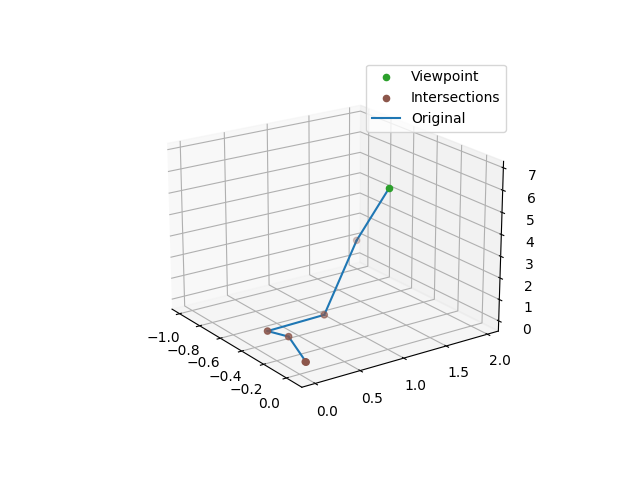

In [18]:
%matplotlib widget
  
# importing required libraries
import matplotlib.pyplot as plt
import numpy as np

ax = plt.figure().add_subplot(projection='3d')

def display_graph(ax, graph_data):
    pos_x, pos_y, pos_z = list(zip(*graph_data.pos))
    ax.scatter(pos_x[0], pos_y[0], pos_z[0], c='tab:green', label='Viewpoint')
    ax.scatter(pos_x[1:], pos_y[1:], pos_z[1:], c='tab:brown', label='Intersections')

    colors = ['tab:blue', 'tab:red']
    labels = ['Original', 'Built']
    labels_exist = [False, False]

    edge_index = np.array(graph_data.edge_index).T

    for c_i, (node_1, node_2) in enumerate(edge_index):
        pos = [graph_data.pos[node_1], graph_data.pos[node_2]]
        pos_x, pos_y, pos_z = list(zip(*pos))
        tag_index = graph_data.edge_tag[c_i].value

        line = ax.plot(pos_x, pos_y, pos_z, color=colors[tag_index])

        if not labels_exist[tag_index]:
            line[0].set_label(labels[tag_index])
            labels_exist[tag_index] = True
    
#display_graph(ax, graph_data_1)
#display_graph(ax, graph_data_2)
display_graph(ax, graphs_samples[1].data)
#display_graph(ax, graph_data_2)
#display_graph(ax, graph_data_3)

ax.view_init(elev=20., azim=-35, roll=0)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.ion()